# Exploratory Data Analysis - Zillow Zestimate Competition

In [8]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib as plt
import seaborn as sns

%matplotlib inline

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "data/"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

properties_2016.csv
sample_submission.csv
train_2016_v2.csv
zillow_data_dictionary.xlsx



### Look at the Data Dictionary

In [37]:
def print_dictionary_tables(input_path):
    try:
        excel_file = pd.ExcelFile(input_path)
        dfs = []
        for sheet in excel_file.sheet_names:
            print(sheet)
            df = excel_file.parse(sheet)
            if df.shape[1] == 2:
                for i in range(df.shape[0]):
                    print(df[df.columns[0]][i], ' - ' + df[df.columns[1]][i])
                df['Table'] = sheet
                dfs.append(df)
            else:
                print("Too many dimensions to print.")
            print(' ')
            print(' ')
        return dfs
    except:
        "Dimensions incorrect."

In [38]:
dict_dfs = print_dictionary_tables('data/zillow_data_dictionary.xlsx')

Data Dictionary
'airconditioningtypeid'  -  Type of cooling system present in the home (if any)
'architecturalstyletypeid'  -  Architectural style of the home (i.e. ranch, colonial, split-level, etc…)
'basementsqft'  -  Finished living area below or partially below ground level
'bathroomcnt'  -  Number of bathrooms in home including fractional bathrooms
'bedroomcnt'  -  Number of bedrooms in home 
'buildingqualitytypeid'  -  Overall assessment of condition of the building from best (lowest) to worst (highest)
'buildingclasstypeid'  - The building framing type (steel frame, wood frame, concrete/brick) 
'calculatedbathnbr'  -  Number of bathrooms in home including fractional bathroom
'decktypeid'  - Type of deck (if any) present on parcel
'threequarterbathnbr'  -  Number of 3/4 bathrooms in house (shower + sink + toilet)
'finishedfloor1squarefeet'  -  Size of the finished living area on the first (entry) floor of the home
'calculatedfinishedsquarefeet'  -  Calculated total finished livin

In [43]:
dict_dfs[4]

,AirConditioningTypeID,AirConditioningDesc,Table
0,1,Central,AirConditioningTypeID
1,2,Chilled Water,AirConditioningTypeID
2,3,Evaporative Cooler,AirConditioningTypeID
3,4,Geo Thermal,AirConditioningTypeID
4,5,None,AirConditioningTypeID
5,6,Other,AirConditioningTypeID
6,7,Packaged AC Unit,AirConditioningTypeID
7,8,Partial,AirConditioningTypeID
8,9,Refrigeration,AirConditioningTypeID
9,10,Ventilation,AirConditioningTypeID


#### End of data dictionary exploration.

## Explore Training Set File

In [5]:
train = pd.read_csv('data/train_2016_v2.csv')

In [6]:
train.head()

,parcelid,logerror,transactiondate
0,11016594,0.0276,2016-01-01
1,14366692,-0.1684,2016-01-01
2,12098116,-0.0040,2016-01-01
3,12643413,0.0218,2016-01-02
4,14432541,-0.0050,2016-01-02


In [7]:
train.shape

(90275, 3)

In [77]:
train.parcelid.value_counts().head()

11842707    3
12613442    2
12032773    2
11729067    2
11845988    2
Name: parcelid, dtype: int64

In [82]:
# Are the 3 rows different?
train[train['parcelid'] == 11842707]

,parcelid,logerror,transactiondate
55794,11842707,-0.0284,2016-07-14
55795,11842707,0.0573,2016-08-22
55796,11842707,0.2078,2016-09-29


So, some are duplicated, but only one happened 3 times.
The parcel with 3 appearances had 3 different transaction dates, and went up with each date. That'll be something to look at in the parcels set.

In [75]:
train.logerror.describe()

count    90275.000000
mean         0.011457
std          0.161079
min         -4.605000
25%         -0.025300
50%          0.006000
75%          0.039200
max          4.737000
Name: logerror, dtype: float64

In [81]:
train.transactiondate.value_counts().head()

2016-07-29    910
2016-04-29    902
2016-09-30    894
2016-06-30    874
2016-05-27    863
Name: transactiondate, dtype: int64

Lots of duplication in dates. A couple only have one entry.

#### End of training set exploration.

## Explore Properties File

In [44]:
properties = pd.read_csv('data/properties_2016.csv', low_memory=False)

In [45]:
properties.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,9.0,2015.0,9.0,NaN,NaN,NaN,NaN
1,10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN
2,10843547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,650756.0,1413387.0,2015.0,762631.0,20800.37,NaN,NaN,NaN
3,10859147,NaN,NaN,NaN,0.0,0.0,3.0,7.0,NaN,NaN,...,1.0,NaN,571346.0,1156834.0,2015.0,585488.0,14557.57,NaN,NaN,NaN
4,10879947,NaN,NaN,NaN,0.0,0.0,4.0,NaN,NaN,NaN,...,NaN,NaN,193796.0,433491.0,2015.0,239695.0,5725.17,NaN,NaN,NaN


In [48]:
properties.shape

(2985217, 58)

#### For categoricals, I will fill NaNs with a -1, for 'no category'.

In [46]:
ac = dict_dfs[4].copy()

In [51]:
properties = properties.merge(ac, how='left', left_on='airconditioningtypeid', right_on='AirConditioningTypeID')

In [53]:
properties.drop(['AirConditioningTypeID', 'Table'], axis=1, inplace=True)

In [56]:
properties.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,AirConditioningDesc
0,10754147,-1.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,9.0,2015.0,9.0,NaN,NaN,NaN,NaN,Not Specified
1,10759547,-1.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN,Not Specified
2,10843547,-1.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,650756.0,1413387.0,2015.0,762631.0,20800.37,NaN,NaN,NaN,Not Specified
3,10859147,-1.0,NaN,NaN,0.0,0.0,3.0,7.0,NaN,NaN,...,NaN,571346.0,1156834.0,2015.0,585488.0,14557.57,NaN,NaN,NaN,Not Specified
4,10879947,-1.0,NaN,NaN,0.0,0.0,4.0,NaN,NaN,NaN,...,NaN,193796.0,433491.0,2015.0,239695.0,5725.17,NaN,NaN,NaN,Not Specified


In [55]:
properties['airconditioningtypeid'].fillna(value=-1, inplace=True)
properties['AirConditioningDesc'].fillna(value='Not Specified', inplace=True)

In [66]:
properties['AirConditioningDesc'].value_counts()

Not Specified         2173698
Central                742364
Yes                     58457
None                     8795
Wall Unit                1818
Window Unit                59
Refrigeration              19
Evaporative Cooler          7
Name: AirConditioningDesc, dtype: int64

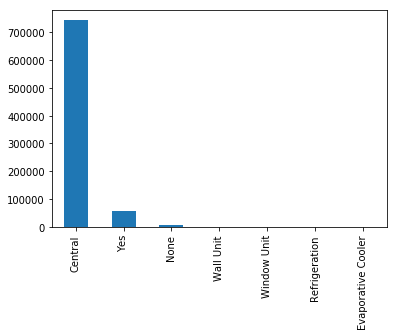

In [120]:
properties.AirConditioningDesc.value_counts()[1:].plot(kind='bar')

In [75]:
arch = dict_dfs[5].copy()

In [76]:
arch.head()

,ArchitecturalStyleTypeID,ArchitecturalStyleDesc,Table
0,1,A-Frame,ArchitecturalStyleTypeID
1,2,Bungalow,ArchitecturalStyleTypeID
2,3,Cape Cod,ArchitecturalStyleTypeID
3,4,Cottage,ArchitecturalStyleTypeID
4,5,Colonial,ArchitecturalStyleTypeID


In [77]:
properties = properties.merge(arch, how='left', left_on='architecturalstyletypeid', right_on='ArchitecturalStyleTypeID')

In [80]:
properties.drop(['ArchitecturalStyleTypeID', 'Table'], axis=1, inplace=True)

In [79]:
properties['architecturalstyletypeid'].fillna(value=-1, inplace=True)
properties['ArchitecturalStyleDesc'].fillna(value='Not Specified', inplace=True)

In [81]:
properties.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,AirConditioningDesc,ArchitecturalStyleDesc
0,10754147,-1.0,-1.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,9.0,2015.0,9.0,NaN,NaN,NaN,NaN,Not Specified,Not Specified
1,10759547,-1.0,-1.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN,Not Specified,Not Specified
2,10843547,-1.0,-1.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,650756.0,1413387.0,2015.0,762631.0,20800.37,NaN,NaN,NaN,Not Specified,Not Specified
3,10859147,-1.0,-1.0,NaN,0.0,0.0,3.0,7.0,NaN,NaN,...,571346.0,1156834.0,2015.0,585488.0,14557.57,NaN,NaN,NaN,Not Specified,Not Specified
4,10879947,-1.0,-1.0,NaN,0.0,0.0,4.0,NaN,NaN,NaN,...,193796.0,433491.0,2015.0,239695.0,5725.17,NaN,NaN,NaN,Not Specified,Not Specified


In [82]:
properties['ArchitecturalStyleDesc'].value_counts()

Not Specified        2979156
Contemporary            5251
Conventional             380
Bungalow                 201
Ranch/Rambler            150
Cape Cod                  58
Colonial                  19
Victorian                  1
French Provincial          1
Name: ArchitecturalStyleDesc, dtype: int64

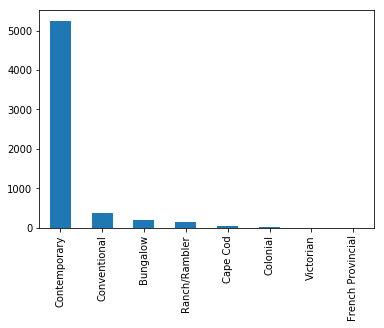

In [119]:
properties['ArchitecturalStyleDesc'].value_counts()[1:].plot(kind='bar')

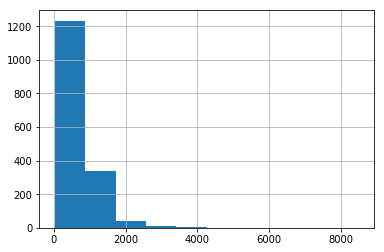

In [84]:
properties['basementsqft'].hist()

In [85]:
properties['basementsqft'].describe()

count    1628.000000
mean      646.883292
std       538.793473
min        20.000000
25%       272.000000
50%       534.000000
75%       847.250000
max      8516.000000
Name: basementsqft, dtype: float64

In [86]:
# Since there are no zeros, and this won't be a negative value, I'll fill na's with 0
properties['basementsqft'].fillna(value=0, inplace=True)

In [87]:
properties['basementsqft'].describe()

count    2.985217e+06
mean     3.527804e-01
std      1.965456e+01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      8.516000e+03
Name: basementsqft, dtype: float64

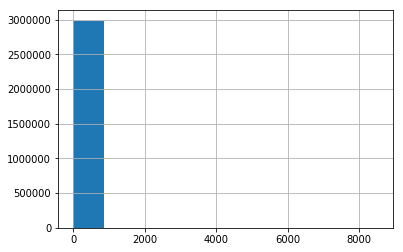

In [88]:
properties['basementsqft'].hist()

In [89]:
properties.shape[0] - 1628

2983589

In [90]:
# It looks like a vast majority don't have finished basements!

In [91]:
properties.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,AirConditioningDesc,ArchitecturalStyleDesc
0,10754147,-1.0,-1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,9.0,2015.0,9.0,NaN,NaN,NaN,NaN,Not Specified,Not Specified
1,10759547,-1.0,-1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN,Not Specified,Not Specified
2,10843547,-1.0,-1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,...,650756.0,1413387.0,2015.0,762631.0,20800.37,NaN,NaN,NaN,Not Specified,Not Specified
3,10859147,-1.0,-1.0,0.0,0.0,0.0,3.0,7.0,NaN,NaN,...,571346.0,1156834.0,2015.0,585488.0,14557.57,NaN,NaN,NaN,Not Specified,Not Specified
4,10879947,-1.0,-1.0,0.0,0.0,0.0,4.0,NaN,NaN,NaN,...,193796.0,433491.0,2015.0,239695.0,5725.17,NaN,NaN,NaN,Not Specified,Not Specified


In [97]:
properties['bathroomcnt'].count()

2973755

In [98]:
properties.shape[0]

2985217

In [99]:
properties.shape[0] - properties['bathroomcnt'].count()

11462

In [101]:
properties.shape[0] - properties['bedroomcnt'].count()

11450

In [110]:
bc = dict_dfs[7].copy()

In [112]:
properties = properties.merge(bc, how='left', left_on='buildingclasstypeid', right_on='BuildingClassTypeID')

In [113]:
properties.drop(['BuildingClassTypeID', 'Table'], axis=1, inplace=True)

In [114]:
properties.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,AirConditioningDesc,ArchitecturalStyleDesc,BuildingClassDesc
0,10754147,-1.0,-1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,...,9.0,2015.0,9.0,NaN,NaN,NaN,NaN,Not Specified,Not Specified,NaN
1,10759547,-1.0,-1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,...,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN,Not Specified,Not Specified,NaN
2,10843547,-1.0,-1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,...,1413387.0,2015.0,762631.0,20800.37,NaN,NaN,NaN,Not Specified,Not Specified,NaN
3,10859147,-1.0,-1.0,0.0,0.0,0.0,3,7.0,NaN,NaN,...,1156834.0,2015.0,585488.0,14557.57,NaN,NaN,NaN,Not Specified,Not Specified,Buildings having exterior walls built of a non...
4,10879947,-1.0,-1.0,0.0,0.0,0.0,4,NaN,NaN,NaN,...,433491.0,2015.0,239695.0,5725.17,NaN,NaN,NaN,Not Specified,Not Specified,Buildings having wood or wood and steel frames


In [115]:
properties['buildingclasstypeid'].fillna(value=-1, inplace=True)
properties['BuildingClassDesc'].fillna(value='Not Specified', inplace=True)

In [116]:
properties['BuildingClassDesc'].value_counts()

Not Specified                                                                                                                                                                                                                              2972588
Buildings having wood or wood and steel frames                                                                                                                                                                                                9265
Buildings having exterior walls built of a non-combustible material such as brick, concrete, block or poured concrete. Interior partitions and roof structures are built of combustible materials. Floor may be concrete or wood frame.       3161
Buildings having fireproofed reinforced concrete frames carrying all wall floor and roof loads which are all non-combustible.                                                                                                                   81
Buildings having fireproofed

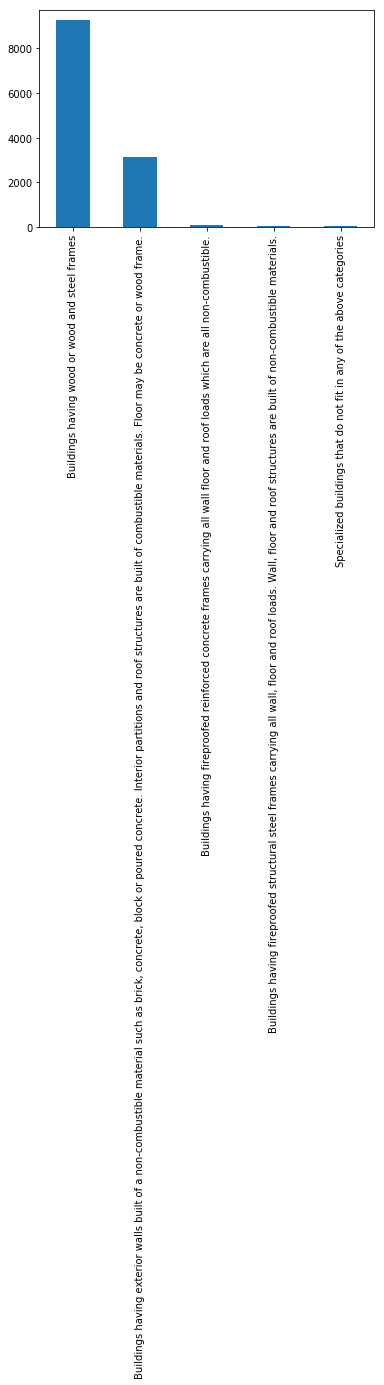

In [118]:
properties['BuildingClassDesc'].value_counts()[1:].plot(kind='bar')

In [121]:
properties.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,AirConditioningDesc,ArchitecturalStyleDesc,BuildingClassDesc
0,10754147,-1.0,-1.0,0.0,0.0,0.0,-1.0,NaN,NaN,NaN,...,9.0,2015.0,9.0,NaN,NaN,NaN,NaN,Not Specified,Not Specified,Not Specified
1,10759547,-1.0,-1.0,0.0,0.0,0.0,-1.0,NaN,NaN,NaN,...,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN,Not Specified,Not Specified,Not Specified
2,10843547,-1.0,-1.0,0.0,0.0,0.0,-1.0,NaN,NaN,NaN,...,1413387.0,2015.0,762631.0,20800.37,NaN,NaN,NaN,Not Specified,Not Specified,Not Specified
3,10859147,-1.0,-1.0,0.0,0.0,0.0,3.0,7.0,NaN,NaN,...,1156834.0,2015.0,585488.0,14557.57,NaN,NaN,NaN,Not Specified,Not Specified,Buildings having exterior walls built of a non...
4,10879947,-1.0,-1.0,0.0,0.0,0.0,4.0,NaN,NaN,NaN,...,433491.0,2015.0,239695.0,5725.17,NaN,NaN,NaN,Not Specified,Not Specified,Buildings having wood or wood and steel frames


In [146]:
properties['buildingqualitytypeid'].value_counts()

7.0     1133238
4.0      692160
1.0       69467
10.0      39713
12.0       3692
6.0          94
8.0          51
9.0          25
5.0          21
11.0         19
3.0           6
2.0           2
Name: buildingqualitytypeid, dtype: int64

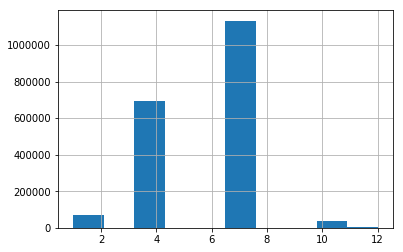

In [149]:
properties['buildingqualitytypeid'].hist()

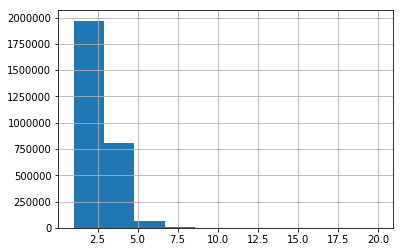

In [151]:
properties['calculatedbathnbr'].hist()

In [154]:
# Percentage which are NaN
(properties.shape[0] - properties['calculatedbathnbr'].count())/properties.shape[0]

0.043183460364857901

In [156]:
# There is only a single value. It's pretty well, has a deck or doesn't have a deck. Going to fill N/A with negative one and treat this as categorical
properties['decktypeid'].value_counts()

66.0    17096
Name: decktypeid, dtype: int64

In [158]:
properties['decktypeid'].fillna(-1, inplace=True)

In [204]:
properties.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,AirConditioningDesc,ArchitecturalStyleDesc,BuildingClassDesc
0,10754147,-1.0,-1.0,0.0,0.0,0.0,-1.0,NaN,NaN,-1.0,...,9.0,2015.0,9.0,NaN,NaN,NaN,NaN,Not Specified,Not Specified,Not Specified
1,10759547,-1.0,-1.0,0.0,0.0,0.0,-1.0,NaN,NaN,-1.0,...,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN,Not Specified,Not Specified,Not Specified
2,10843547,-1.0,-1.0,0.0,0.0,0.0,-1.0,NaN,NaN,-1.0,...,1413387.0,2015.0,762631.0,20800.37,NaN,NaN,NaN,Not Specified,Not Specified,Not Specified
3,10859147,-1.0,-1.0,0.0,0.0,0.0,3.0,7.0,NaN,-1.0,...,1156834.0,2015.0,585488.0,14557.57,NaN,NaN,NaN,Not Specified,Not Specified,Buildings having exterior walls built of a non...
4,10879947,-1.0,-1.0,0.0,0.0,0.0,4.0,NaN,NaN,-1.0,...,433491.0,2015.0,239695.0,5725.17,NaN,NaN,NaN,Not Specified,Not Specified,Buildings having wood or wood and steel frames


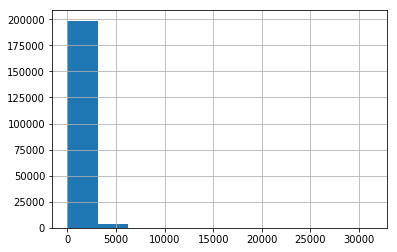

In [161]:
properties['finishedfloor1squarefeet'].hist()

In [163]:
properties['finishedfloor1squarefeet'].count()

202717

In [165]:
# Percentage not having a value. Derive what can be derived from similar values, and do a cluster median for the rest.
(properties.shape[0] - properties['finishedfloor1squarefeet'].count())/properties.shape[0]

0.93209304382227487

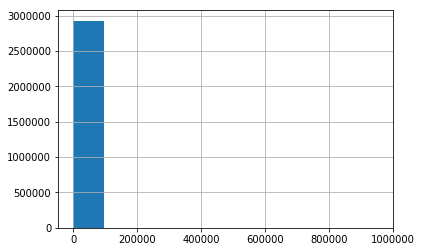

In [166]:
properties['calculatedfinishedsquarefeet'].hist()

In [168]:
properties['calculatedfinishedsquarefeet'].count()

2929652

In [167]:
(properties.shape[0] - properties['calculatedfinishedsquarefeet'].count())/properties.shape[0]

0.018613387234495852

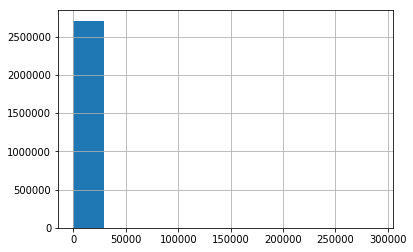

In [171]:
properties['finishedsquarefeet12'].hist()

In [172]:
properties['finishedsquarefeet12'].count()

2709184

In [173]:
(properties.shape[0] - properties['finishedsquarefeet12'].count())/properties.shape[0]

0.092466644803376102

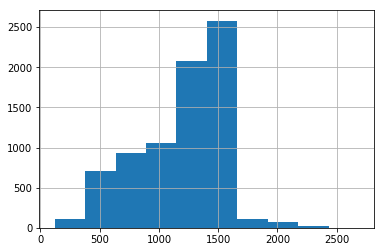

In [175]:
properties['finishedsquarefeet13'].hist()

In [176]:
properties['finishedsquarefeet13'].count()

7672

In [177]:
(properties.shape[0] - properties['finishedsquarefeet13'].count())/properties.shape[0]

0.9974300025760271

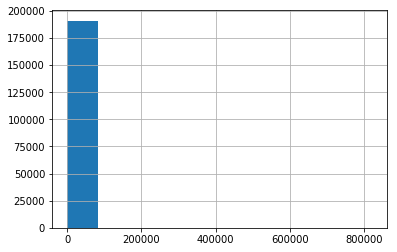

In [179]:
properties['finishedsquarefeet15'].hist()

In [180]:
properties['finishedsquarefeet15'].count()

190798

In [181]:
(properties.shape[0] - properties['finishedsquarefeet15'].count())/properties.shape[0]

0.93608571839166133

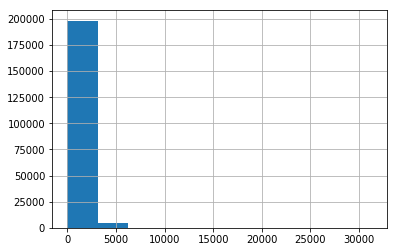

In [183]:
properties['finishedsquarefeet50'].hist()

In [184]:
properties['finishedsquarefeet50'].count()

202717

In [185]:
(properties.shape[0] - properties['finishedsquarefeet50'].count())/properties.shape[0]

0.93209304382227487

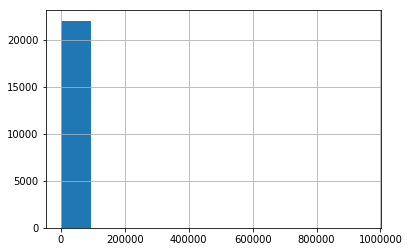

In [187]:
properties['finishedsquarefeet6'].hist()

In [188]:
properties['finishedsquarefeet6'].count()

22001

In [189]:
(properties.shape[0] - properties['finishedsquarefeet6'].count())/properties.shape[0]

0.99263001651136251

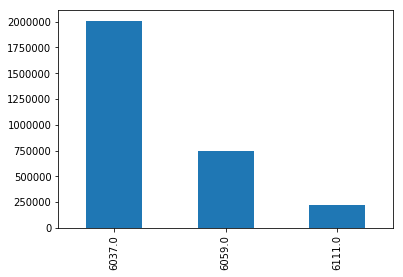

In [193]:
properties['fips'].value_counts().plot(kind='bar')

In [194]:
(properties.shape[0] - properties['fips'].count())/properties.shape[0]

0.0038312122703307665

In [197]:
print(properties.shape[0])
print(properties['fips'].count())

2985217
2973780


In [198]:
properties.shape[0] - properties['fips'].count()

11437

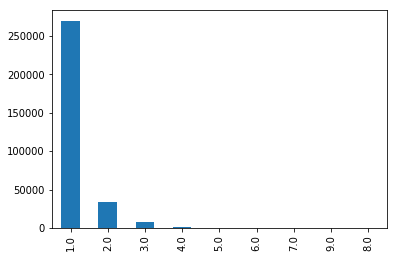

In [200]:
properties['fireplacecnt'].value_counts().plot(kind='bar')

In [201]:
properties['fireplacecnt'].value_counts()

1.0    269643
2.0     34407
3.0      7696
4.0       710
5.0       126
6.0        32
7.0        15
9.0         6
8.0         2
Name: fireplacecnt, dtype: int64

In [203]:
# No zero, so I CAN do a fillna with zero on this one.
properties['fireplacecnt'].fillna(value=0, inplace=True)

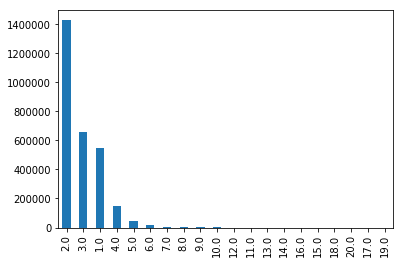

In [205]:
properties['fullbathcnt'].value_counts().plot(kind='bar')

In [206]:
properties['fullbathcnt'].value_counts()

2.0     1425661
3.0      660139
1.0      544928
4.0      151004
5.0       43918
6.0       17198
7.0        6409
8.0        4557
9.0        1339
10.0        498
12.0        263
11.0        204
13.0         53
14.0         45
16.0         30
15.0         23
18.0         15
20.0         10
17.0          7
19.0          4
Name: fullbathcnt, dtype: int64

In [207]:
# Again, no zero, so I can fillna with zero.
properties['fullbathcnt'].fillna(0, inplace=True)

In [122]:
properties.columns

Index(['parcelid', 'airconditioningtypeid', 'architecturalstyletypeid',
       'basementsqft', 'bathroomcnt', 'bedroomcnt', 'buildingclasstypeid',
       'buildingqualitytypeid', 'calculatedbathnbr', 'decktypeid',
       'finishedfloor1squarefeet', 'calculatedfinishedsquarefeet',
       'finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15',
       'finishedsquarefeet50', 'finishedsquarefeet6', 'fips', 'fireplacecnt',
       'fullbathcnt', 'garagecarcnt', 'garagetotalsqft', 'hashottuborspa',
       'heatingorsystemtypeid', 'latitude', 'longitude', 'lotsizesquarefeet',
       'poolcnt', 'poolsizesum', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7',
       'propertycountylandusecode', 'propertylandusetypeid',
       'propertyzoningdesc', 'rawcensustractandblock', 'regionidcity',
       'regionidcounty', 'regionidneighborhood', 'regionidzip', 'roomcnt',
       'storytypeid', 'threequarterbathnbr', 'typeconstructiontypeid',
       'unitcnt', 'yardbuildingsqft17', 'yardbuildin

In [123]:
properties['taxvaluedollarcnt'].describe()

count    2.942667e+06
mean     4.204790e+05
std      7.263467e+05
min      1.000000e+00
25%      1.796750e+05
50%      3.060860e+05
75%      4.880000e+05
max      2.827860e+08
Name: taxvaluedollarcnt, dtype: float64

In [126]:
properties.columns

Index(['parcelid', 'airconditioningtypeid', 'architecturalstyletypeid',
       'basementsqft', 'bathroomcnt', 'bedroomcnt', 'buildingclasstypeid',
       'buildingqualitytypeid', 'calculatedbathnbr', 'decktypeid',
       'finishedfloor1squarefeet', 'calculatedfinishedsquarefeet',
       'finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15',
       'finishedsquarefeet50', 'finishedsquarefeet6', 'fips', 'fireplacecnt',
       'fullbathcnt', 'garagecarcnt', 'garagetotalsqft', 'hashottuborspa',
       'heatingorsystemtypeid', 'latitude', 'longitude', 'lotsizesquarefeet',
       'poolcnt', 'poolsizesum', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7',
       'propertycountylandusecode', 'propertylandusetypeid',
       'propertyzoningdesc', 'rawcensustractandblock', 'regionidcity',
       'regionidcounty', 'regionidneighborhood', 'regionidzip', 'roomcnt',
       'storytypeid', 'threequarterbathnbr', 'typeconstructiontypeid',
       'unitcnt', 'yardbuildingsqft17', 'yardbuildin

In [134]:
# So, do all records have a target variable?
properties.shape[0] - properties['landtaxvaluedollarcnt'].count()

67733

In [132]:
# TODO: See if any of these have a value at another point in time. Use that to fill n/a if available, or else take a median based on other characteristics.
(properties.shape[0] - properties['landtaxvaluedollarcnt'].count())/properties.shape[0]

0.022689472825593582

In [202]:
# Constructing of list of variables to fill later. Need to be zero, but REAL zeroes are present.
no_zero_na = ['bathroomcnt','bedroomcnt']
fill_with_median_or_mode_from_cluster = ['buildingqualitytypeid','fips']
fill_w_cluster_median_or_derive = ['finishedfloor1squarefeet', 'calculatedfinishedsquarefeet', 'finishedsquarefeet12',
                                  'finishedsquarefeet13', 'finishedsquarefeet15', 'finishedsquarefeet50',
                                  'finishedsquarefeet6']

#### End of properties file exploration.